In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.laguerre import laggauss
from numpy import linalg
from scipy.stats import norm

## Introduction

We want to solve a Fredholm integral equation of the second kind, of the form:

$u(x) = \int_{0}^{\infty} K(x, t) u(t) dt + f(x)$

We'll approach it by using Gauss-Laguerre quadrature to approximate the integral (note that we have to insert $\exp(t)$ to cancel the implicit $\exp(-t)$ weighting function of the G-L quadrature.):

$u(x) \approx \sum_{j=1}^{n} w_j \exp(t_j) K(x, t_j) u(t_j) + f(x)$

If we evaluate $u$ at the quadrature points ($u_i = u(x_i)$), we get a linear system:

$u_i \approx \sum_{j=1}^{n} w_j \exp(x_j) K(x_i, x_j) u_j + f(x_i)$

In matrix form, we have:

$A \vec{u} = \vec{b}$

$A_{i,j} = \delta_{i,j} - w_j exp(x_j) K(x_i, x_j)$

$b_i = f(x_i)$

We can solve this for $\vec{u}$. Then to get the continuous function $u(x)$, we can substitute $\vec{u}$ into the right-hand side of the approximation above:

$u(x) \approx \sum_{j=1}^{n} w_j \exp(t_j) K(x, t_j) u_j + f(x)$

In [2]:
def solve_fredholm(k, f, n):
    x, w = laggauss(n)
    A = np.eye(n) - w * np.exp(x) * k(x[:,None], x)
    b = f(x)
    u = linalg.solve(A, b)
    def soln(y):
        return np.dot(w * np.exp(x) * k(y[:,None], x), u) + f(y)
    return soln

In [3]:
def k(mu, sigma):
    return lambda x, t: norm(loc=mu, scale=sigma).pdf(t - x)

def f_nt(mu, sigma):
    return norm(loc=-mu, scale=sigma).sf

def f_t():
    return np.ones_like

As we increase the number of nodes, we approach the asymptotic behavior (in $x$) that we expect from theory.

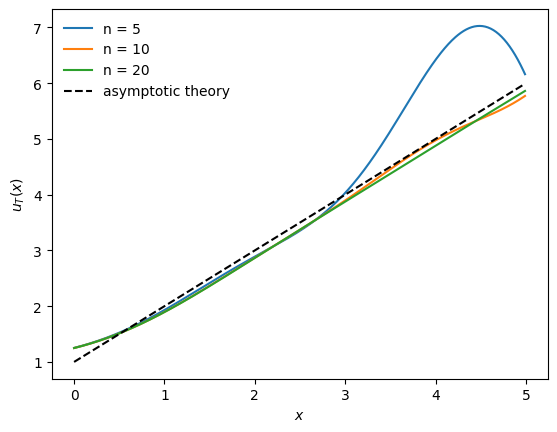

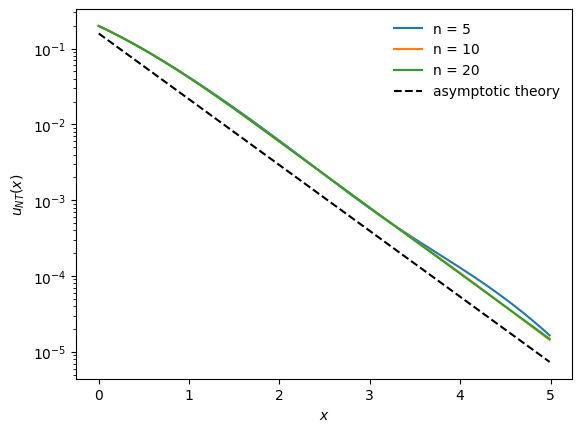

In [4]:
mu = 1
sigma = 1

xmax = 5
x = np.arange(0, xmax, 0.01)

for n in [5, 10, 20]:
    plt.plot(x, solve_fredholm(k(-mu, sigma), f_t(), n)(x), label = f"n = {n}")
plt.plot(x, x / mu + 1, 'k--', label="asymptotic theory")
plt.legend(frameon=False)
plt.xlabel(r"$x$")
plt.ylabel(r"$u_T(x)$")
plt.show()

for n in [5, 10, 20]:
    plt.semilogy(x, solve_fredholm(k(mu, sigma), f_nt(mu, sigma), n)(x), label = f"n = {n}")
plt.plot(x, norm.cdf(-mu/sigma) * np.exp(-2 * mu * x / sigma**2), 'k--', label="asymptotic theory")
plt.legend(frameon=False)
plt.xlabel(r"$x$")
plt.ylabel(r"$u_{NT}(x)$")
plt.show()

## Scaling diagrams

In [5]:
n = 185
sigma = 1

### Threat, $|\mu / \sigma| \ge 1$

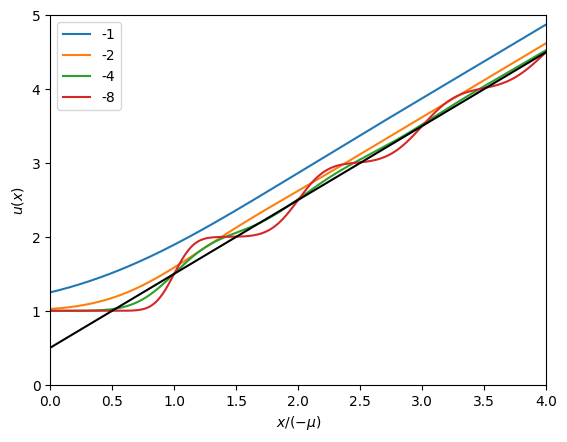

In [6]:
xmax = 32
x = np.arange(0, xmax, 0.01)

for mu in [-1, -2, -4, -8]:
    soln = solve_fredholm(k(mu, sigma), f_t(), n)
    plt.plot(x / (-mu), soln(x), label=mu)
plt.plot(x, x + 0.5, 'k')
plt.xlim([0, 4])
plt.ylim([0, 5])
plt.xlabel(r"$x / (-\mu)$")
plt.ylabel(r"$u(x)$")
plt.legend()

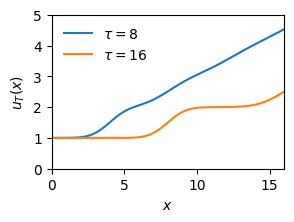

In [7]:
xmax = 16
x = np.arange(0, xmax, 0.01)

plt.figure(figsize=(3,2))
for mu in [-4, -8]:
    soln = solve_fredholm(k(mu, sigma), f_t(), n)
    plt.plot(x, soln(x), label=r"$\tau = $" + f"{-2 * mu}")
plt.xlim([0, xmax])
plt.ylim([0, 5])
plt.xlabel(r"$x$")
plt.ylabel(r"$u_T(x)$")
plt.legend(frameon=False)
plt.savefig("large_updates.png", bbox_inches="tight")

### Non-threat, $|\mu / \sigma| \ge 1$

One term from the Liouville-Neumann series:

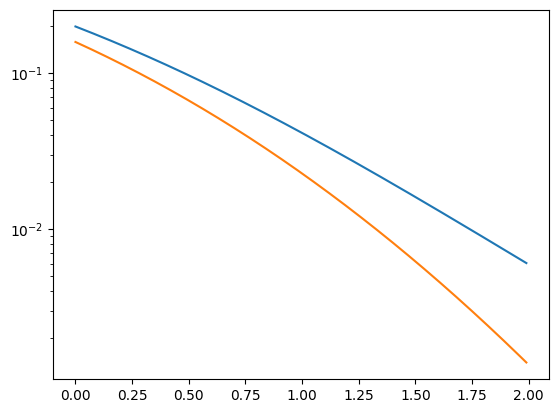

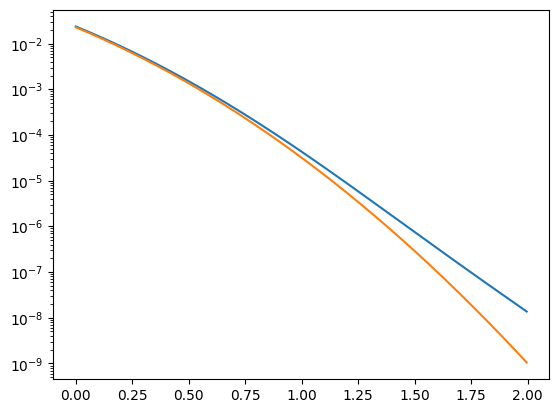

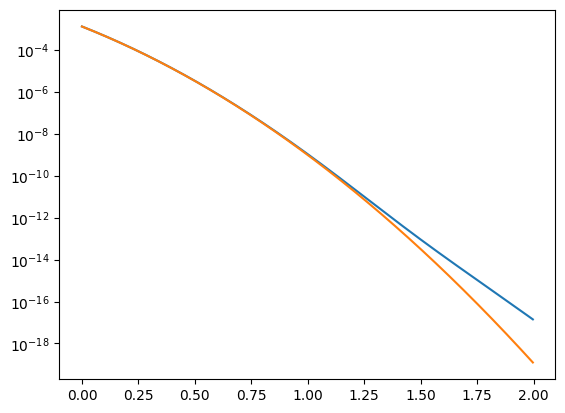

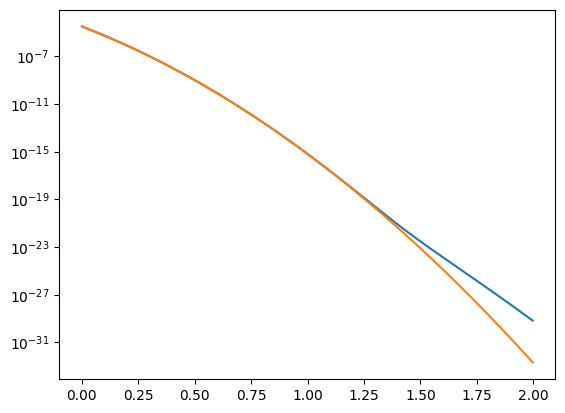

In [8]:
for mu in [1, 2, 3, 4]:
    xmax = 2*mu
    x = np.arange(0, xmax, 0.01)

    soln = solve_fredholm(k(mu, sigma), f_nt(mu, sigma), n)
    plt.semilogy(x / mu, soln(x), label=mu)
    plt.semilogy(x / mu, norm.cdf(-(x+mu)/sigma))
    plt.show()

Multiple terms from the Liouville-Neumann series:

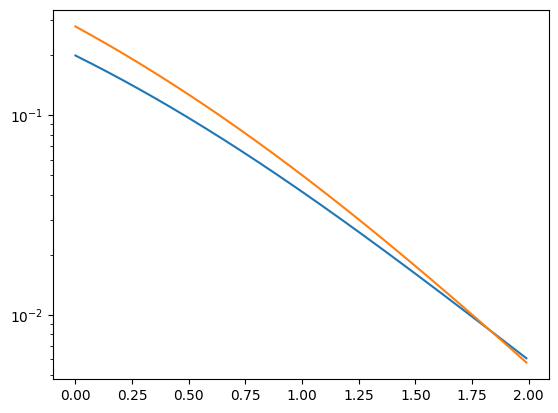

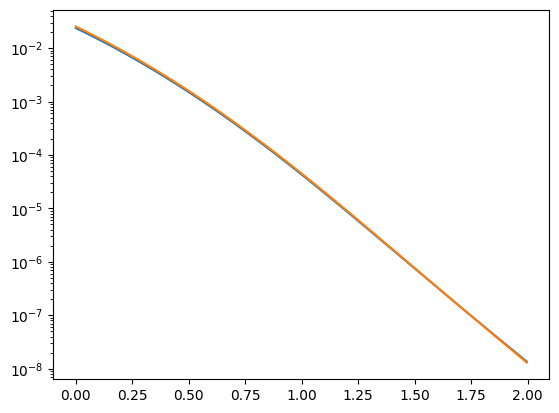

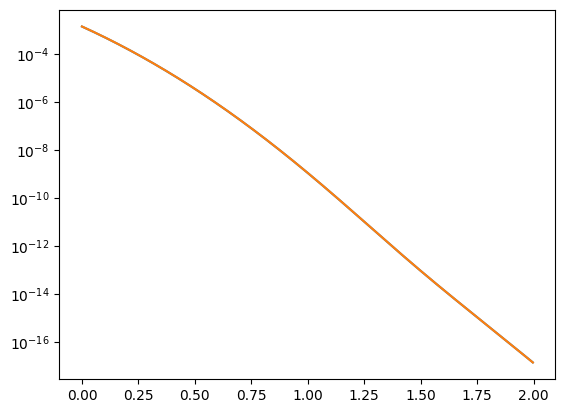

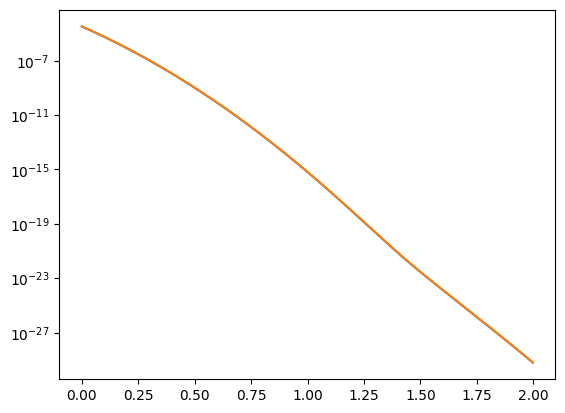

In [9]:
for mu in [1, 2, 3, 4]:
    xmax = 2*mu
    x = np.arange(0, xmax, 0.01)

    soln = solve_fredholm(k(mu, sigma), f_nt(mu, sigma), n)
    approx = np.zeros_like(x)
    for j in range(1, 4):
        approx += norm.cdf(-(x + j * mu)/(np.sqrt(j) * sigma))
    plt.semilogy(x / mu, soln(x), label=mu)
    plt.semilogy(x / mu, approx)
    plt.show()

### Non-threat, $|\mu / \sigma| \leq 1$

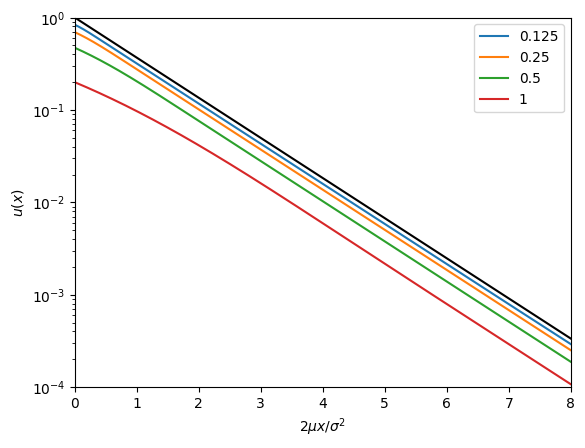

In [10]:
xmax = 32
x = np.arange(0, xmax, 0.01)

for mu in [1/8, 1/4, 1/2, 1]:
    soln = solve_fredholm(k(mu, sigma), f_nt(mu, sigma), n)
    plt.semilogy(2 * mu * x / sigma**2, soln(x), label=mu)
plt.semilogy(x, np.exp(- x), 'k')
plt.xlim([0, 8])
plt.ylim([1e-4,1])
plt.xlabel(r"$2 \mu x / \sigma^2$")
plt.ylabel(r"$u(x)$")
plt.legend()

Testing the hypothesis that $u_{NT}(0) \sim \frac{1}{1 + \sqrt{\tau/2}}$ for $\tau \to 0$.

(0.0, 1.0)

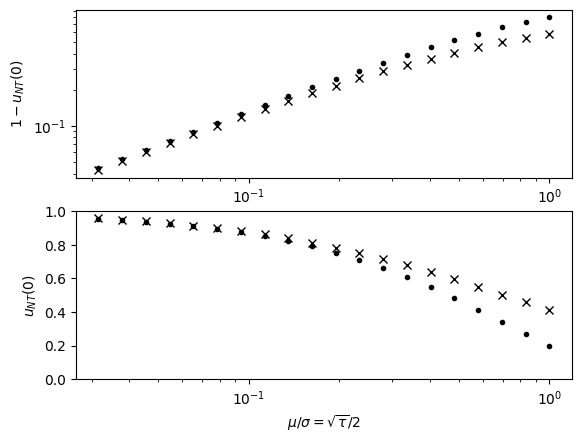

In [11]:
plt.subplot(211)
for mu in np.logspace(-1.5, 0, 20):
    soln = solve_fredholm(k(mu, sigma), f_nt(mu, sigma), n)
    plt.loglog(mu, 1 - soln(np.zeros(1)), '.k')
    plt.loglog(mu, 1 - 1 / (1 + np.sqrt(2)*mu / sigma), 'xk')
plt.ylabel(r"$1 - u_{NT}(0)$")

plt.subplot(212)
for mu in np.logspace(-1.5, 0, 20):
    soln = solve_fredholm(k(mu, sigma), f_nt(mu, sigma), n)
    plt.semilogx(mu, soln(np.zeros(1)), '.k')
    plt.semilogx(mu, 1 / (1 + np.sqrt(2)*mu / sigma), 'xk')

plt.xlabel(r"$\mu / \sigma = \sqrt{\tau}/2$")
plt.ylabel(r"$u_{NT}(0)$")
plt.ylim([0,1])

### Threat, $|\mu / \sigma| \le 1$

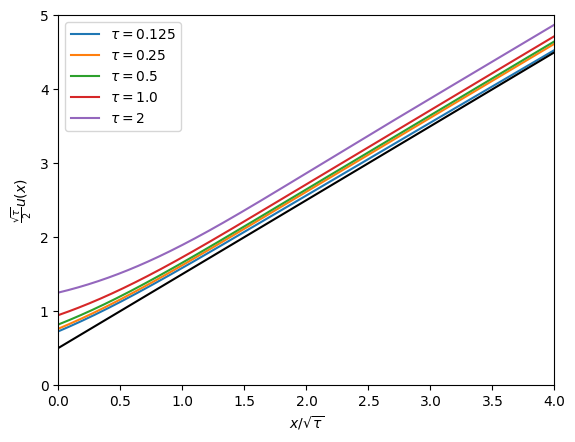

In [12]:
xmax = 32
x = np.arange(0, xmax, 0.01)

for mu in [-1/16, -1/8, -1/4, -1/2, -1]:
    soln = solve_fredholm(k(mu, sigma), f_t(), n)
    plt.plot(x / sigma, soln(x) * (-mu / sigma), label=r"$\tau = $" + f"{-2*mu}")
plt.plot(x, x + 0.5, 'k')
plt.xlim([0, 4])
plt.ylim([0, 5])
plt.xlabel(r"$x / \sqrt{\tau}$")
plt.ylabel(r"$\frac{\sqrt{\tau}}{2} u(x)$")
plt.legend()

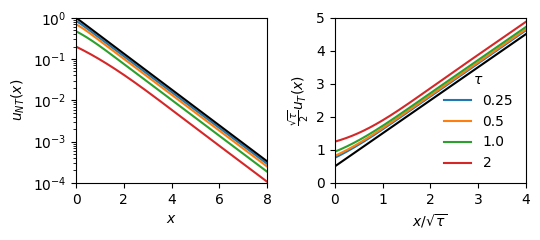

In [13]:
xmax = 32
x = np.arange(0, xmax, 0.01)

fig = plt.figure(figsize=(5.5,2.5))

ax = plt.subplot(122)
for mu in [-1/8, -1/4, -1/2, -1]:
    soln = solve_fredholm(k(mu, sigma), f_t(), n)
    plt.plot(x / sigma, soln(x) * (-mu / sigma), label=f"{-2*mu}")
plt.plot(x, x + 0.5, 'k')
plt.xlim([0, 4])
plt.ylim([0, 5])
plt.xlabel(r"$x / \sqrt{\tau}$")
plt.ylabel(r"$\frac{\sqrt{\tau}}{2} u_{T}(x)$")
plt.legend(frameon=False, title=r"$\tau$")


xmax = 32
x = np.arange(0, xmax, 0.01)

ax = plt.subplot(121)
for mu in [1/8, 1/4, 1/2, 1]:
    soln = solve_fredholm(k(mu, sigma), f_nt(mu, sigma), n)
    plt.semilogy(2 * mu * x / sigma**2, soln(x), label=mu)
plt.semilogy(x, np.exp(- x), 'k')
plt.xlim([0, 8])
plt.ylim([1e-4,1])
plt.xlabel(r"$x$")
plt.ylabel(r"$u_{NT}(x)$")

fig.tight_layout()
plt.savefig("small_updates.png", bbox_inches="tight")
# plt.legend()

## Scratch

Attempts at higher-order approximations, fitting the constants, etc.

In [14]:
def theory_nt(x, mu, sigma):
    return (norm.cdf(-mu/sigma) / norm.cdf(mu/sigma)) * np.exp(-2 * mu * x / sigma**2)

def theory_t(x, mu, sigma):
    a = 1 + np.abs(sigma/mu) * norm.pdf(np.abs(mu/sigma)) / norm.cdf(np.abs(mu/sigma))
    return - (1/mu) * x + a

(0.0, 4.0)

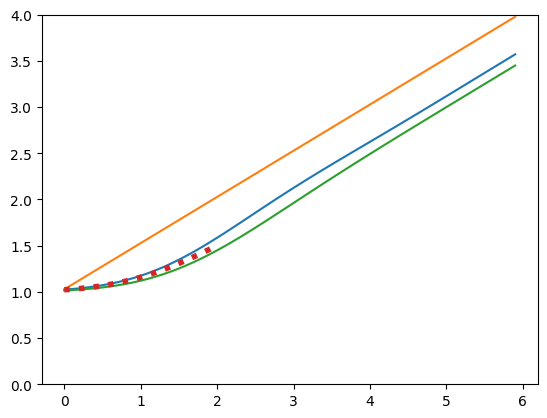

In [15]:
mu = -2
sigma = 1
n = 185

soln = solve_fredholm(k(mu, sigma), f_t(), n)

xmax = 6
x = np.arange(0, xmax, 0.1)

plt.plot(x, soln(x))
plt.plot(x, theory_t(x, mu, sigma))
# a = 1 + np.abs(sigma/mu) * norm.pdf(np.abs(mu/sigma)) / norm.cdf(np.abs(mu/sigma))
a = 1/2
plt.plot(x, 1 - (sigma/mu)*norm.pdf((x+mu)/sigma) + (- (x/mu) + a - 1)*norm.cdf((x+mu)/sigma))
plt.plot(x[x<=-mu], 1 + norm.cdf((x[x<=-mu]+mu)/sigma), ':', lw=4)
plt.ylim([0,1 - xmax/mu])

In [16]:
def a_opt(x):
    return 1/2 + 1/(2*x) - (1/x)*norm.pdf(1/2 + x/2) / norm.cdf(-(1/2 + x/2))

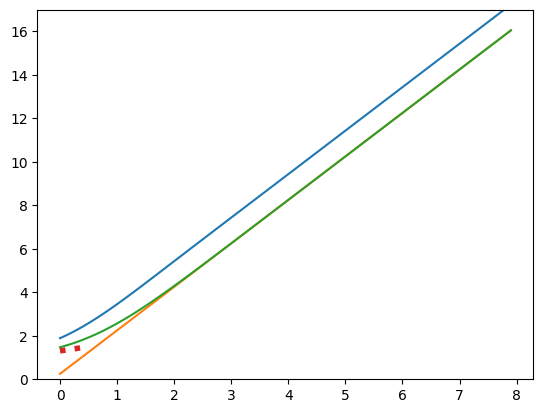

1.4271079588328082
1.2821555407361296


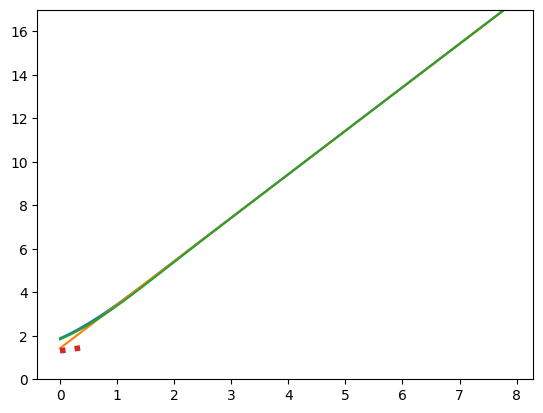

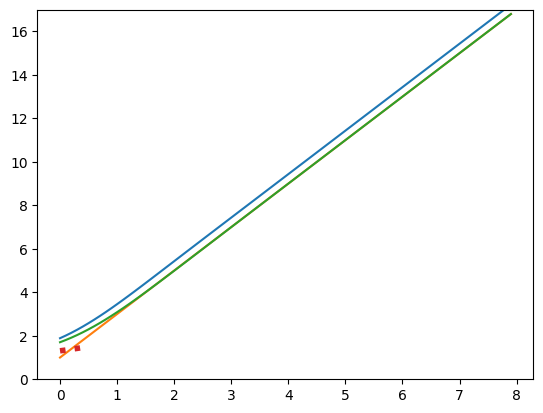

In [17]:
mu = -1/2
sigma = 1
n = 185

soln = solve_fredholm(k(mu, sigma), f_t(), n)

xmax = 8
x = np.arange(0, xmax, 0.1)

a = 1/4
plt.plot(x, soln(x))
plt.plot(x, -(x/mu) + a)
plt.plot(x, 1 - (sigma/mu)*norm.pdf((x+mu)/sigma) + (- (x/mu) + a - 1)*norm.cdf((x+mu)/sigma))
plt.plot(x[x<=-mu], 1 + norm.cdf((x[x<=-mu]+mu)/sigma), ':', lw=4)
plt.ylim([0,1 - xmax/mu])
plt.show()

a = a_opt(mu/sigma)
print(a)
print(-sigma / mu * (norm.pdf(1/2) / norm.cdf(-1/2) - 1/2))
plt.plot(x, soln(x))
plt.plot(x, -(x/mu) + a)
plt.plot(x, 1 - (sigma/mu)*norm.pdf((x+mu)/sigma) + (- (x/mu) + a - 1)*norm.cdf((x+mu)/sigma))
plt.plot(x[x<=-mu], 1 + norm.cdf((x[x<=-mu]+mu)/sigma), ':', lw=4)
plt.ylim([0,1 - xmax/mu])
plt.show()

a = 1
plt.plot(x, soln(x))
plt.plot(x, -(x/mu) + a)
plt.plot(x, 1 - (sigma/mu)*norm.pdf((x+mu)/sigma) + (- (x/mu) + a - 1)*norm.cdf((x+mu)/sigma))
plt.plot(x[x<=-mu], 1 + norm.cdf((x[x<=-mu]+mu)/sigma), ':', lw=4)
plt.ylim([0,1 - xmax/mu])
plt.show()



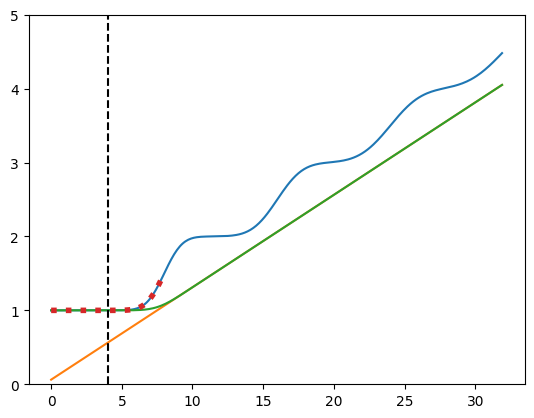

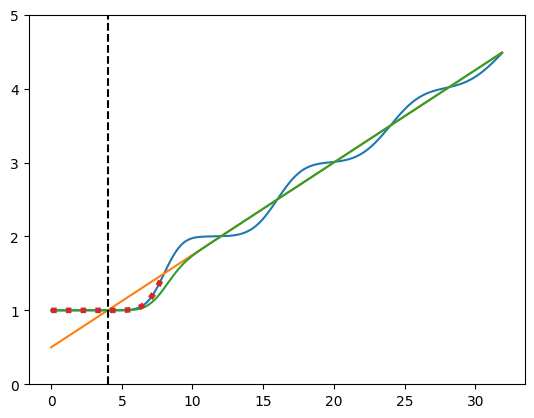

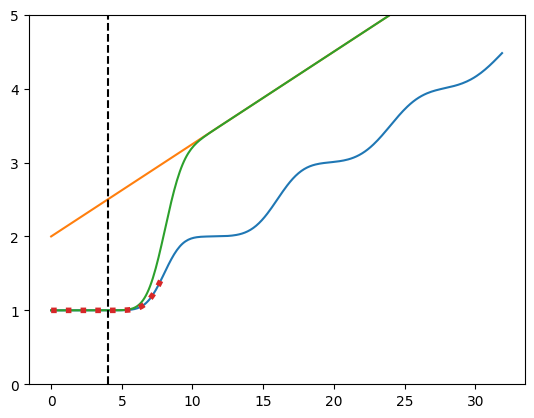

In [18]:
mu = -8
sigma = 1
n = 185

soln = solve_fredholm(k(mu, sigma), f_t(), n)

xmax = 32
x = np.arange(0, xmax, 0.1)

a = 1/16
plt.plot(x, soln(x))
plt.plot(x, -(x/mu) + a)
plt.plot(x, 1 - (sigma/mu)*norm.pdf((x+mu)/sigma) + (- (x/mu) + a - 1)*norm.cdf((x+mu)/sigma))
plt.plot(x[x<=-mu], 1 + norm.cdf((x[x<=-mu]+mu)/sigma), ':', lw=4)
plt.vlines((-mu) / 2, 0, 1 - xmax/mu, 'k', linestyle='dashed')
plt.ylim([0,1 - xmax/mu])
plt.show()

a = 1/2
plt.plot(x, soln(x))
plt.plot(x, -(x/mu) + a)
plt.plot(x, 1 - (sigma/mu)*norm.pdf((x+mu)/sigma) + (- (x/mu) + a - 1)*norm.cdf((x+mu)/sigma))
plt.plot(x[x<=-mu], 1 + norm.cdf((x[x<=-mu]+mu)/sigma), ':', lw=4)
plt.vlines((-mu) / 2, 0, 1 - xmax/mu, 'k', linestyle='dashed')
plt.ylim([0,1 - xmax/mu])
plt.show()

a = 2
plt.plot(x, soln(x))
plt.plot(x, -(x/mu) + a)
plt.plot(x, 1 - (sigma/mu)*norm.pdf((x+mu)/sigma) + (- (x/mu) + a - 1)*norm.cdf((x+mu)/sigma))
plt.plot(x[x<=-mu], 1 + norm.cdf((x[x<=-mu]+mu)/sigma), ':', lw=4)
plt.vlines((-mu) / 2, 0, 1 - xmax/mu, 'k', linestyle='dashed')
plt.ylim([0,1 - xmax/mu])
plt.show()



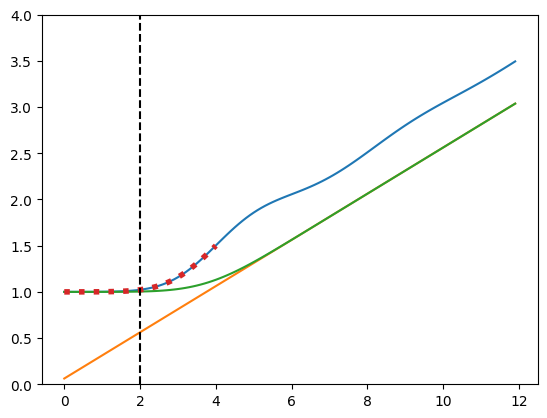

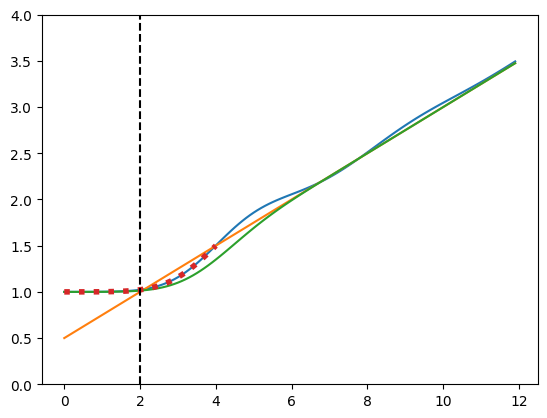

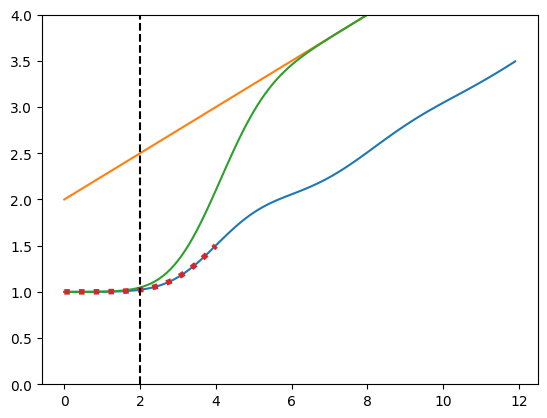

In [19]:
mu = -4
sigma = 1
n = 185

soln = solve_fredholm(k(mu, sigma), f_t(), n)

xmax = 12
x = np.arange(0, xmax, 0.1)

a = 1/16
plt.plot(x, soln(x))
plt.plot(x, -(x/mu) + a)
plt.plot(x, 1 - (sigma/mu)*norm.pdf((x+mu)/sigma) + (- (x/mu) + a - 1)*norm.cdf((x+mu)/sigma))
plt.plot(x[x<=-mu], 1 + norm.cdf((x[x<=-mu]+mu)/sigma), ':', lw=4)
plt.vlines((-mu) / 2, 0, 1 - xmax/mu, 'k', linestyle='dashed')
plt.ylim([0,1 - xmax/mu])
plt.show()

a = 1/2
plt.plot(x, soln(x))
plt.plot(x, -(x/mu) + a)
plt.plot(x, 1 - (sigma/mu)*norm.pdf((x+mu)/sigma) + (- (x/mu) + a - 1)*norm.cdf((x+mu)/sigma))
plt.plot(x[x<=-mu], 1 + norm.cdf((x[x<=-mu]+mu)/sigma), ':', lw=4)
plt.vlines((-mu) / 2, 0, 1 - xmax/mu, 'k', linestyle='dashed')
plt.ylim([0,1 - xmax/mu])
plt.show()

a = 2
plt.plot(x, soln(x))
plt.plot(x, -(x/mu) + a)
plt.plot(x, 1 - (sigma/mu)*norm.pdf((x+mu)/sigma) + (- (x/mu) + a - 1)*norm.cdf((x+mu)/sigma))
plt.plot(x[x<=-mu], 1 + norm.cdf((x[x<=-mu]+mu)/sigma), ':', lw=4)
plt.vlines((-mu) / 2, 0, 1 - xmax/mu, 'k', linestyle='dashed')
plt.ylim([0,1 - xmax/mu])
plt.show()



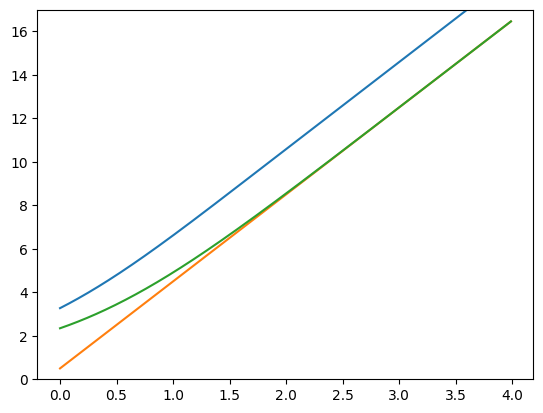

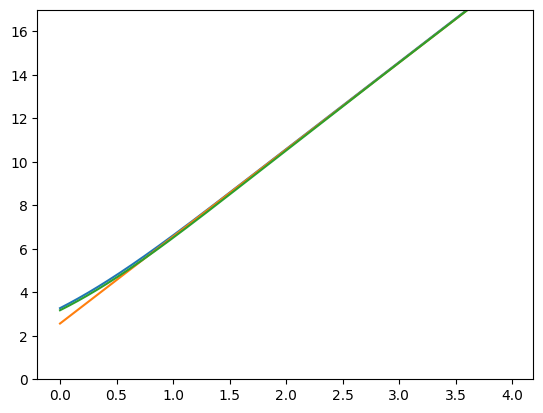

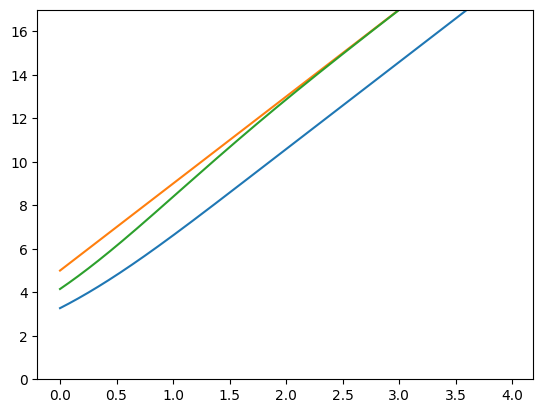

In [20]:
mu = -1/4
sigma = 1
n = 185

soln = solve_fredholm(k(mu, sigma), f_t(), n)

xmax = 4
x = np.arange(0, xmax, 0.01)

a = 1/2
plt.plot(x, soln(x))
plt.plot(x, -(x/mu) + a)
plt.plot(x, 1 - (sigma/mu)*norm.pdf((x+mu)/sigma) + (- (x/mu) + a - 1)*norm.cdf((x+mu)/sigma))
plt.ylim([0,1 - xmax/mu])
plt.show()

a = 0.641 * sigma / (-mu)
plt.plot(x, soln(x))
plt.plot(x, -(x/mu) + a)
plt.plot(x, 1 - (sigma/mu)*norm.pdf((x+mu)/sigma) + (- (x/mu) + a - 1)*norm.cdf((x+mu)/sigma))
plt.ylim([0,1 - xmax/mu])
plt.show()

a = 5
plt.plot(x, soln(x))
plt.plot(x, -(x/mu) + a)
plt.plot(x, 1 - (sigma/mu)*norm.pdf((x+mu)/sigma) + (- (x/mu) + a - 1)*norm.cdf((x+mu)/sigma))
plt.ylim([0,1 - xmax/mu])
plt.show()


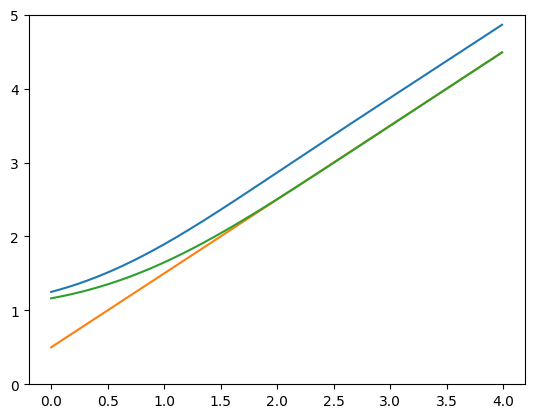

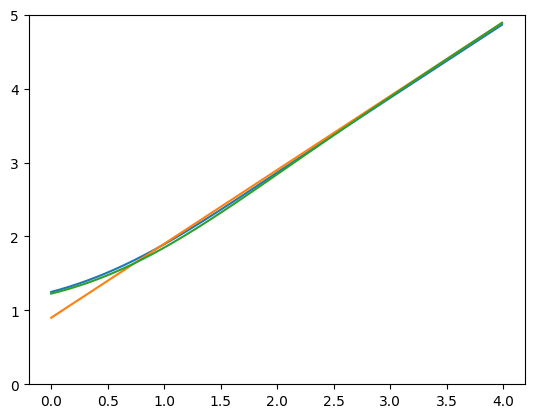

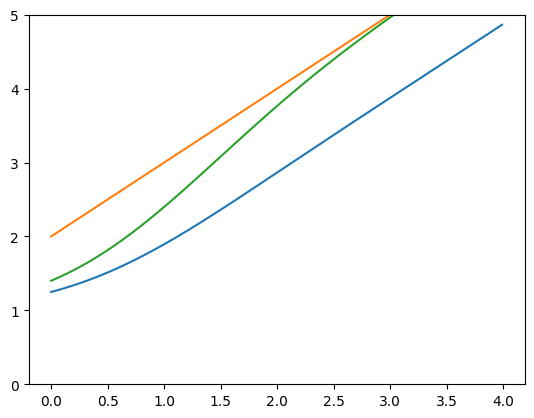

In [21]:
mu = -1
sigma = 1
n = 185

soln = solve_fredholm(k(mu, sigma), f_t(), n)

xmax = 4
x = np.arange(0, xmax, 0.01)

a = 1/2
plt.plot(x, soln(x))
plt.plot(x, -(x/mu) + a)
plt.plot(x, 1 - (sigma/mu)*norm.pdf((x+mu)/sigma) + (- (x/mu) + a - 1)*norm.cdf((x+mu)/sigma))
plt.ylim([0,1 - xmax/mu])
plt.show()

a = 0.9
plt.plot(x, soln(x))
plt.plot(x, -(x/mu) + a)
plt.plot(x, 1 - (sigma/mu)*norm.pdf((x+mu)/sigma) + (- (x/mu) + a - 1)*norm.cdf((x+mu)/sigma))
plt.ylim([0,1 - xmax/mu])
plt.show()

a = 2
plt.plot(x, soln(x))
plt.plot(x, -(x/mu) + a)
plt.plot(x, 1 - (sigma/mu)*norm.pdf((x+mu)/sigma) + (- (x/mu) + a - 1)*norm.cdf((x+mu)/sigma))
plt.ylim([0,1 - xmax/mu])
plt.show()


(0.0, 4.0)

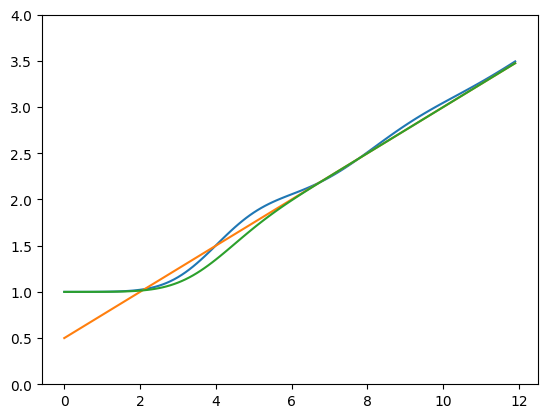

In [22]:
mu = -4
sigma = 1
n = 185

soln = solve_fredholm(k(mu, sigma), f_t(), n)

xmax = 12
x = np.arange(0, xmax, 0.1)

plt.plot(x, soln(x))
a = 1/2
plt.plot(x, -(x/mu) + a)
plt.plot(x, 1 - (sigma/mu)*norm.pdf((x+mu)/sigma) + (- (x/mu) + a - 1)*norm.cdf((x+mu)/sigma))
plt.ylim([0,1 - xmax/mu])

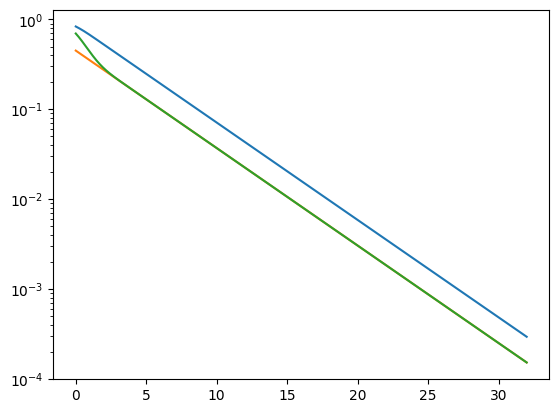

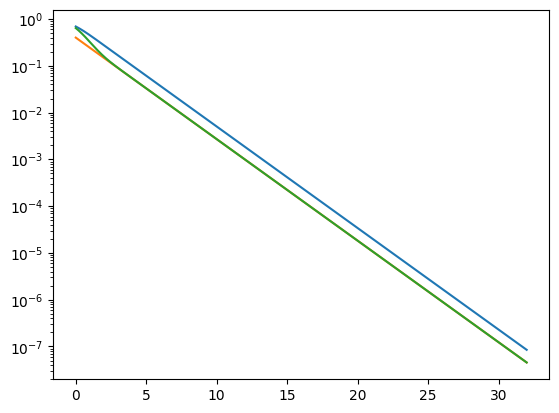

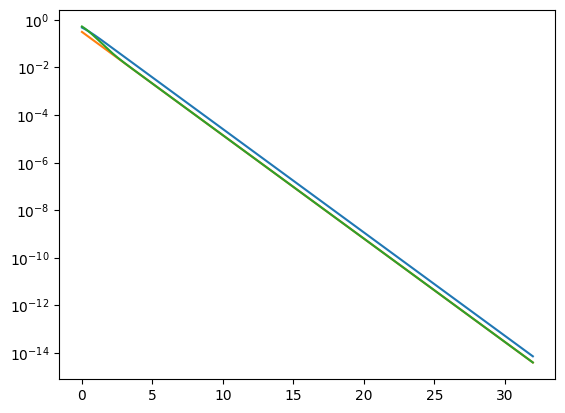

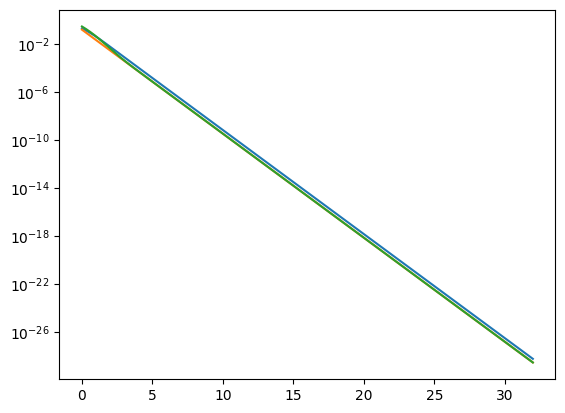

In [23]:
xmax = 32
x = np.arange(0, xmax, 0.01)

for mu in [1/8, 1/4, 1/2, 1]:
    a = norm.cdf(-mu / sigma)
    soln = solve_fredholm(k(mu, sigma), f_nt(mu, sigma), n)
    plt.semilogy(x, soln(x), label=mu)
    plt.semilogy(x, a * np.exp(-2 * mu * x / sigma**2))
    plt.semilogy(x, a * norm.sf(-(x+mu)/sigma) * np.exp(-2 * mu * x / sigma**2) + norm.cdf(-(x+mu)/sigma))
    # plt.semilogy(x, np.exp(-2 * x), 'k')
    # plt.xlim([0,4])
    # plt.ylim([3e-3,1.1])
    plt.show()

(0.0, 33.0)

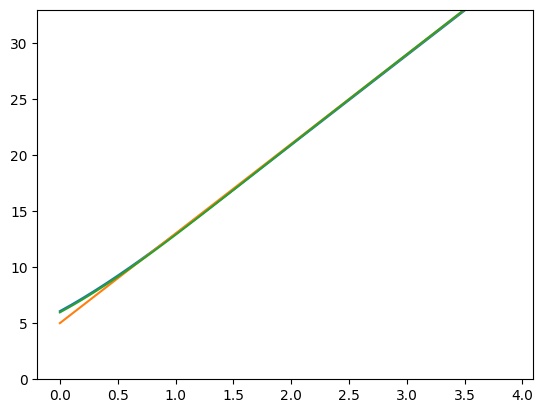

In [24]:
mu = -1/8
sigma = 1
n = 185

soln = solve_fredholm(k(mu, sigma), f_t(), n)

xmax = 4
x = np.arange(0, xmax, 0.1)

plt.plot(x, soln(x))
a = 2 * np.sqrt(2*np.pi)
plt.plot(x, -(x/mu) + a)
plt.plot(x, 1 - (sigma/mu)*norm.pdf((x+mu)/sigma) + (- (x/mu) + a - 1)*norm.cdf((x+mu)/sigma))
plt.ylim([0,1 - xmax/mu])

In [25]:
np.sqrt(2*np.pi)

2.5066282746310002

(0.0, 17.0)

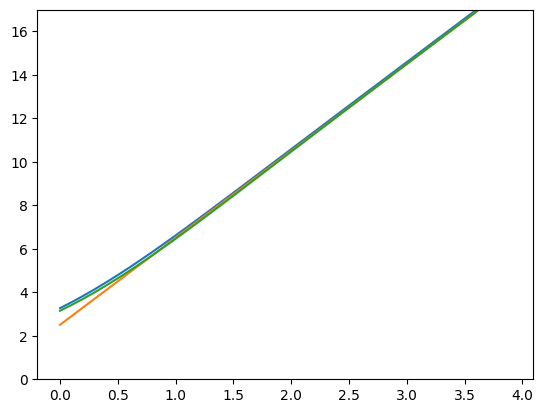

In [26]:
mu = -1/4
sigma = 1
n = 185

soln = solve_fredholm(k(mu, sigma), f_t(), n)

xmax = 4
x = np.arange(0, xmax, 0.1)

plt.plot(x, soln(x))
a = np.sqrt(2*np.pi)
plt.plot(x, -(x/mu) + a)
plt.plot(x, 1 - (sigma/mu)*norm.pdf((x+mu)/sigma) + (- (x/mu) + a - 1)*norm.cdf((x+mu)/sigma))
plt.ylim([0,1 - xmax/mu])

(0.0, 9.0)

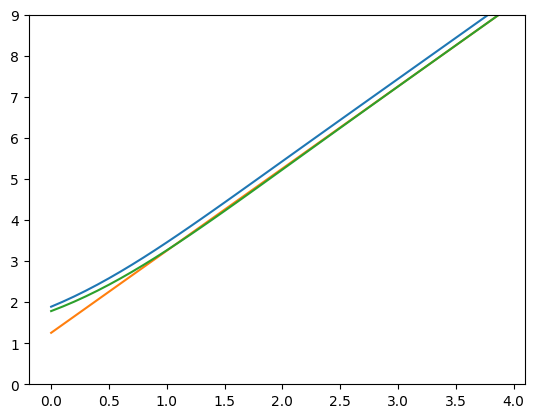

In [27]:
mu = -1/2
sigma = 1
n = 185

soln = solve_fredholm(k(mu, sigma), f_t(), n)

xmax = 4
x = np.arange(0, xmax, 0.1)

plt.plot(x, soln(x))
a = np.sqrt(2*np.pi) / 2
plt.plot(x, -(x/mu) + a)
plt.plot(x, 1 - (sigma/mu)*norm.pdf((x+mu)/sigma) + (- (x/mu) + a - 1)*norm.cdf((x+mu)/sigma))
plt.ylim([0,1 - xmax/mu])

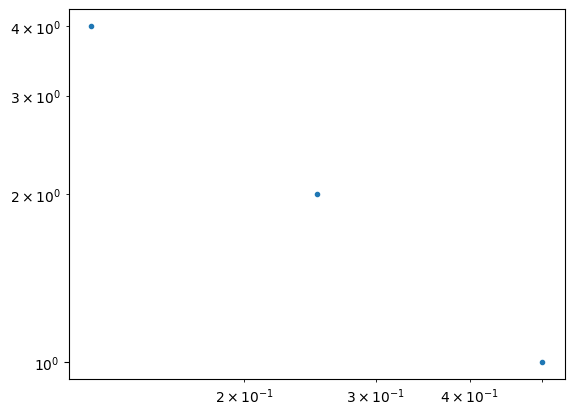

In [28]:
plt.loglog([1/2, 1/4, 1/8], [1, 2, 4], '.')

(0.0, 65.0)

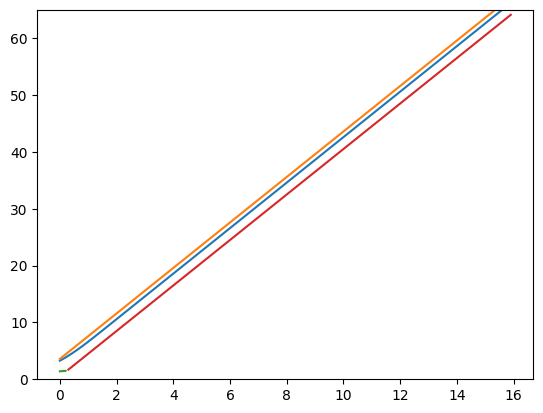

In [29]:
mu = -1/4
sigma = 1
n = 185

soln = solve_fredholm(k(mu, sigma), f_t(), n)

xmax = 16
x = np.arange(0, xmax, 0.1)

plt.plot(x, soln(x))
plt.plot(x, theory_t(x, mu, sigma))
plt.plot(x[x<=-mu], 1 + norm.cdf((x[x<=-mu]+mu)/sigma))
plt.plot(x[x>=-mu], -x[x>=-mu]/mu + 1/2)
plt.ylim([0,1 - xmax/mu])

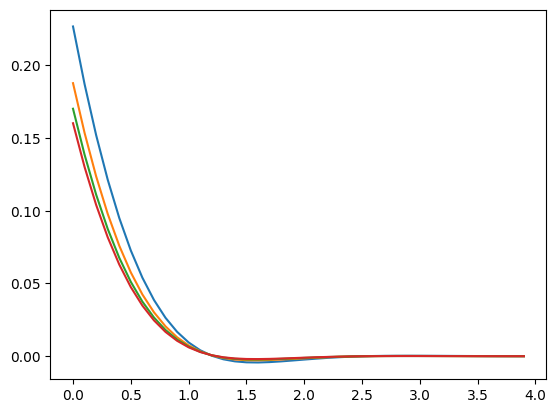

In [30]:
sigma = 1
n = 185
xmax = 4
x = np.arange(0, xmax, 0.1)

for mu in [-1/2, -1/3, -1/4, -1/5]:
    soln = solve_fredholm(k(mu, sigma), f_t(), n)
    mod = soln(x) * -mu - x
    plt.plot(x, mod - mod[-1])
    # plt.plot(x, theory_t(x, mu, sigma) * -mu)

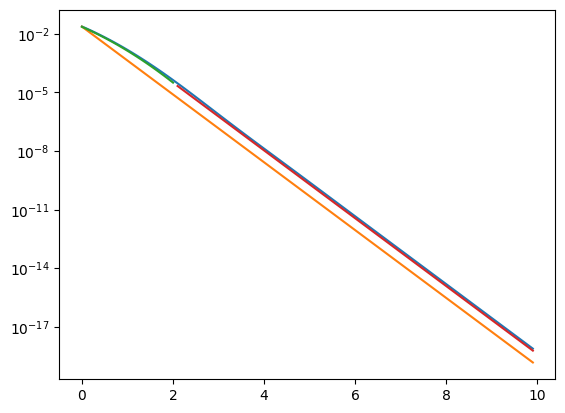

In [31]:
mu = 2
sigma = 1
n = 185

soln = solve_fredholm(k(mu, sigma), f_nt(mu, sigma), n)

xmax = 10
x = np.arange(0, xmax, 0.1)

plt.semilogy(x, soln(x))
# plt.plot(x, 1 + norm.cdf((x+mu)/sigma))
# plt.plot(x, 1 - x/mu)
plt.semilogy(x, theory_nt(x, mu, sigma))
plt.semilogy(x[x<=mu], norm.cdf(-(x[x<=mu]+mu)/sigma))
plt.semilogy(x[x>mu], np.exp(2*(mu/sigma)**2) * norm.cdf(-2*mu/sigma) * np.exp(-2*mu * x[x>mu] / sigma**2))
# plt.plot(x, -x/mu + norm.cdf(0))
# plt.ylim([0,1 - xmax/mu])